In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import pandas as pd

# import the data and the sam data for cleaning, change directory if needed
# the 1st must be the code violations, 2nd the sam addresses, 3rd the building violations, and 4th the property assessment
df1 = pd.read_csv('./data/code_enforcement_violations.csv')
df2 = pd.read_csv('./data/Live_Street_Address_Management_(SAM)_Addresses.csv')
df3 = pd.read_csv('./data/build_prop_violations.csv')
df4 = pd.read_csv('./data/property_assessment.csv')

In [5]:
#Process takes in 3 databases and processes them
def Process(code_vio, prop_vio, sam_addr, prop_assess):
    # rename the columns in the sam dataset to prepare for merging
    prop_assess['PID'] = prop_assess['PID'].astype(str)
    sam_addr.rename(columns={'SAM_ADDRESS_ID': 'sam_id', 'FULL_ADDRESS': 'full_address', 'PARCEL': 'PID'}, inplace=True)
    # select only the wanted columns
    sam_addr = sam_addr[['full_address', 'sam_id', 'PID']]
    # fix sam_id in df3 to get rid of the decimal, just in case
    # we drop missing sam_id & PID for all data
    # sam_addr.dropna(subset = ['PID'], inplace = True)
    prop_vio.dropna(subset = ['sam_id'], inplace = True)
    code_vio.dropna(subset = ['sam_id'], inplace = True)
    # merge the datasets
    sam_addr = pd.merge(sam_addr, prop_assess, on=['PID'], how='left')
    merged_code_vio = pd.merge(code_vio, sam_addr, on=['sam_id'], how='left')
    merged_prop_vio = pd.merge(prop_vio, sam_addr, on=['sam_id'], how='left')
    # drop the empty addresses, caused by missing sam addresses from what I can tell
    merged_code_vio.dropna(subset = ['full_address'], inplace = True)
    merged_prop_vio.dropna(subset = ['full_address'], inplace = True)
    # final clean by dropping apartment numbers ex. 13 Commonwealth #1 -> 13 Commonwealth
    merged_code_vio['full_address'] = merged_code_vio['full_address'].str.split(' #')
    merged_prop_vio['full_address'] = merged_prop_vio['full_address'].str.split(' #')
    # more misc cleaning and final check that all addresses are good if needed
    merged_code_vio.dropna(subset = ['ticket_no'], inplace = True)
    # print(merged_prop_vio.isnull().sum()) # uncomment if needed for checking
    # print(merged_code_vio.isnull().sum())
    return merged_code_vio, merged_prop_vio, sam_addr

In [6]:
# Example call/ Test run
processed_code_vio, processed_prop_vio, sam_addr = Process(df1, df3, df2, df4)

In [7]:
# Display all column names for processing help
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 4000
print(processed_code_vio.columns)

Index(['case_no', 'ticket_no', 'status_dttm', 'status', 'code', 'value',
       'description', 'violation_stno', 'violation_sthigh', 'violation_street',
       'violation_suffix', 'violation_city', 'violation_state',
       'violation_zip', 'ward', 'contact_addr1', 'contact_addr2',
       'contact_city', 'contact_state', 'contact_zip', 'sam_id', 'latitude',
       'longitude', 'location', 'full_address', 'PID', '_id', 'CM_ID',
       'GIS_ID', 'ST_NUM', 'ST_NAME', 'UNIT_NUM', 'CITY', 'ZIP_CODE',
       'BLDG_SEQ', 'NUM_BLDGS', 'LUC', 'LU', 'LU_DESC', 'BLDG_TYPE', 'OWN_OCC',
       'OWNER', 'MAIL_ADDRESSEE', 'MAIL_STREET_ADDRESS', 'MAIL_CITY',
       'MAIL_STATE', 'MAIL_ZIP_CODE', 'RES_FLOOR', 'CD_FLOOR', 'RES_UNITS',
       'COM_UNITS', 'RC_UNITS', 'LAND_SF', 'GROSS_AREA', 'LIVING_AREA',
       'LAND_VALUE', 'BLDG_VALUE', 'SFYI_VALUE', 'TOTAL_VALUE', 'GROSS_TAX',
       'YR_BUILT', 'YR_REMODEL', 'STRUCTURE_CLASS', 'ROOF_STRUCTURE',
       'ROOF_COVER', 'INT_WALL', 'EXT_FNISHED', 'INT_C

In [8]:
processed_code_vio.dropna(subset=['PID'], inplace=True)
processed_prop_vio.dropna(subset=['PID'], inplace=True)

# Calculate violation counts based on 'YR_REMODEL'
conditions_code = processed_code_vio['OVERALL_COND'].value_counts().head(10)
conditions_prop = processed_prop_vio['OVERALL_COND'].value_counts().head(10)

# Get the top 10 property owners based on 'YR_REMODEL' for processed_prop_vio
top_owners_code = processed_code_vio['OVERALL_COND'].value_counts().head(10).index
top_owners_prop = processed_prop_vio['OVERALL_COND'].value_counts().head(10).index

# Filter for the top owners
filtered_code = processed_code_vio[processed_code_vio['OVERALL_COND'].isin(top_owners_code)].explode('full_address')
filtered_prop = processed_prop_vio[processed_prop_vio['OVERALL_COND'].isin(top_owners_prop)].explode('full_address')

# Count unique properties for each year remodeled
unique_code_count = filtered_code.groupby('OVERALL_COND')['full_address'].nunique()
unique_prop_count = filtered_prop.groupby('OVERALL_COND')['full_address'].nunique()

# Create a Series with property counts for each year remodeled
unique_code_series = pd.Series(unique_code_count, index=top_owners_code)
unique_prop_series = pd.Series(unique_prop_count, index=top_owners_prop)

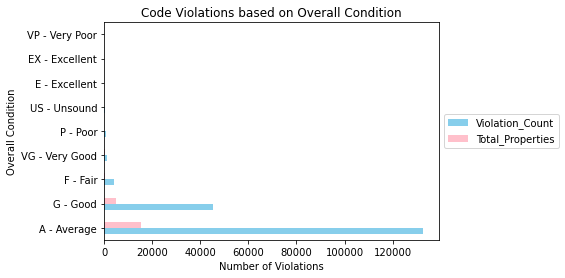

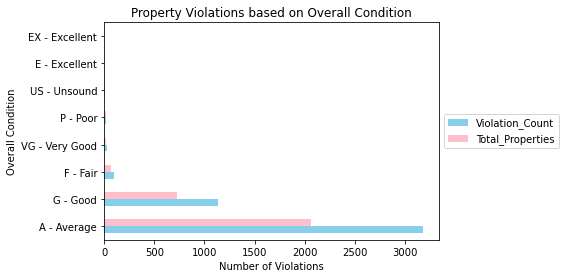

In [9]:
import matplotlib.pyplot as plt
# Convert the data into a pandas Series
series = pd.Series(conditions_code).sort_index(ascending=True)
data_code = pd.DataFrame({'Violation_Count': series, 'Total_Properties': unique_code_series})
data_code_sorted = data_code.sort_values(by='Violation_Count', ascending=False)

# Adding labels and title
ax = data_code_sorted.plot.barh(color=['skyblue','pink'], rot=0, title='Code Violations based on Overall Condition')
plt.xlabel('Number of Violations')
plt.ylabel('Overall Condition')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Convert the data into a pandas Series
series = pd.Series(conditions_prop).sort_index(ascending=True)
data_prop = pd.DataFrame({'Violation_Count': series, 'Total_Properties': unique_prop_series})
data_prop_sorted = data_prop.sort_values(by='Violation_Count', ascending=False)

# Adding labels and title
ax = data_prop_sorted.plot.barh(color=['skyblue','pink'], rot=0, title='Property Violations based on Overall Condition')
plt.xlabel('Number of Violations')
plt.ylabel('Overall Condition')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [10]:
processed_code_vio.dropna(subset=['PID'], inplace=True)
processed_prop_vio.dropna(subset=['PID'], inplace=True)

# Calculate violation counts based on 'BLDG_TYPE'
conditions_code = processed_code_vio['BLDG_TYPE'].value_counts().head(10)
conditions_prop = processed_prop_vio['BLDG_TYPE'].value_counts().head(10)

# Get the top 10 property owners based on 'BLDG_TYPE' for processed_prop_vio
top_owners_code = processed_code_vio['BLDG_TYPE'].value_counts().head(10).index
top_owners_prop = processed_prop_vio['BLDG_TYPE'].value_counts().head(10).index

# Filter for the top owners
filtered_code = processed_code_vio[processed_code_vio['BLDG_TYPE'].isin(top_owners_code)].explode('full_address')
filtered_prop = processed_prop_vio[processed_prop_vio['BLDG_TYPE'].isin(top_owners_prop)].explode('full_address')

# Count unique properties for each year remodeled
unique_code_count = filtered_code.groupby('BLDG_TYPE')['full_address'].nunique()
unique_prop_count = filtered_prop.groupby('BLDG_TYPE')['full_address'].nunique()

# Create a Series with property counts for each year remodeled
unique_code_series = pd.Series(unique_code_count, index=top_owners_code)
unique_prop_series = pd.Series(unique_prop_count, index=top_owners_prop)

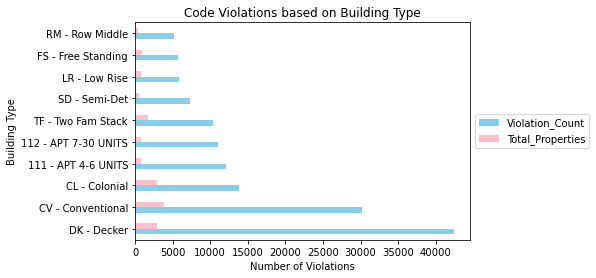

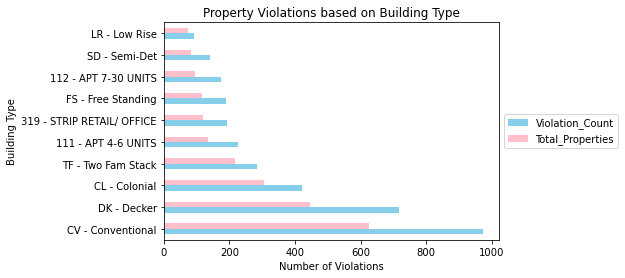

In [11]:
# Convert the data into a pandas Series
series = pd.Series(conditions_code).sort_index(ascending=True)
data_code = pd.DataFrame({'Violation_Count': series, 'Total_Properties': unique_code_series})
data_code_sorted = data_code.sort_values(by='Violation_Count', ascending=False)

# Adding labels and title
ax = data_code_sorted.plot.barh(color=['skyblue','pink'], rot=0, title='Code Violations based on Building Type')
plt.xlabel('Number of Violations')
plt.ylabel('Building Type')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Convert the data into a pandas Series
series = pd.Series(conditions_prop).sort_index(ascending=True)
data_prop = pd.DataFrame({'Violation_Count': series, 'Total_Properties': unique_prop_series})
data_prop_sorted = data_prop.sort_values(by='Violation_Count', ascending=False)

# Adding labels and title
ax = data_prop_sorted.plot.barh(color=['skyblue','pink'], rot=0, title='Property Violations based on Building Type')
plt.xlabel('Number of Violations')
plt.ylabel('Building Type')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [12]:
processed_code_vio.dropna(subset=['PID'], inplace=True)
processed_prop_vio.dropna(subset=['PID'], inplace=True)

# Calculate violation counts based on 'YR_BUILT'
conditions_code = processed_code_vio['YR_BUILT'].value_counts().head(10)
conditions_prop = processed_prop_vio['YR_BUILT'].value_counts().head(10)

# Get the top 10 property owners based on 'YR_BUILT' for processed_prop_vio
top_owners_code = processed_code_vio['YR_BUILT'].value_counts().head(10).index.sort_values(ascending=False)
top_owners_prop = processed_prop_vio['YR_BUILT'].value_counts().head(10).index.sort_values(ascending=False)

# Filter for the top owners
filtered_code = processed_code_vio[processed_code_vio['YR_BUILT'].isin(top_owners_code)].explode('full_address')
filtered_prop = processed_prop_vio[processed_prop_vio['YR_BUILT'].isin(top_owners_prop)].explode('full_address')

# Count unique properties for each year remodeled
unique_code_count = filtered_code.groupby('YR_BUILT')['full_address'].nunique()
unique_prop_count = filtered_prop.groupby('YR_BUILT')['full_address'].nunique()

# Create a Series with property counts for each year remodeled
unique_code_series = pd.Series(unique_code_count, index=top_owners_code)
unique_prop_series = pd.Series(unique_prop_count, index=top_owners_prop)

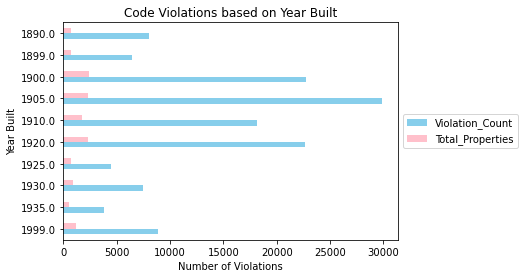

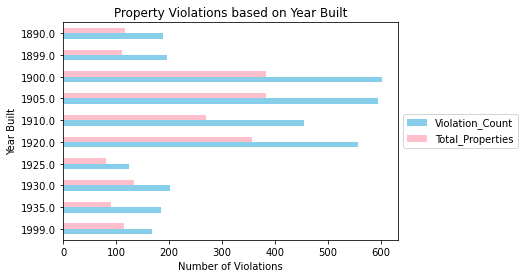

In [13]:
# Convert the data into a pandas Series
series = pd.Series(conditions_code).sort_index(ascending=False)
data_code = pd.DataFrame({'Violation_Count': series, 'Total_Properties': unique_code_series})
data_code_sorted = data_code

# Adding labels and title
ax = data_code_sorted.plot.barh(color=['skyblue','pink'], rot=0, title='Code Violations based on Year Built')
plt.xlabel('Number of Violations')
plt.ylabel('Year Built')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Convert the data into a pandas Series
series = pd.Series(conditions_prop).sort_index(ascending=False)
data_prop = pd.DataFrame({'Violation_Count': series, 'Total_Properties': unique_prop_series})
data_prop_sorted = data_prop

# Adding labels and title
ax = data_prop_sorted.plot.barh(color=['skyblue','pink'], rot=0, title='Property Violations based on Year Built')
plt.xlabel('Number of Violations')
plt.ylabel('Year Built')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [14]:
processed_code_vio.dropna(subset=['PID'], inplace=True)
processed_prop_vio.dropna(subset=['PID'], inplace=True)

# Calculate violation counts based on 'YR_REMODEL'
conditions_code = processed_code_vio['YR_REMODEL'].value_counts().head(10)
conditions_prop = processed_prop_vio['YR_REMODEL'].value_counts().head(10)

# Get the top 10 property owners based on 'YR_REMODEL' for processed_prop_vio
top_owners_code = processed_code_vio['YR_REMODEL'].value_counts().head(10).index.sort_values(ascending=False)
top_owners_prop = processed_prop_vio['YR_REMODEL'].value_counts().head(10).index.sort_values(ascending=False)

# Filter for the top owners
filtered_code = processed_code_vio[processed_code_vio['YR_REMODEL'].isin(top_owners_code)].explode('full_address')
filtered_prop = processed_prop_vio[processed_prop_vio['YR_REMODEL'].isin(top_owners_prop)].explode('full_address')

# Count unique properties for each year remodeled
unique_code_count = filtered_code.groupby('YR_REMODEL')['full_address'].nunique()
unique_prop_count = filtered_prop.groupby('YR_REMODEL')['full_address'].nunique()

# Create a Series with property counts for each year remodeled
unique_code_series = pd.Series(unique_code_count, index=top_owners_code)
unique_prop_series = pd.Series(unique_prop_count, index=top_owners_prop)

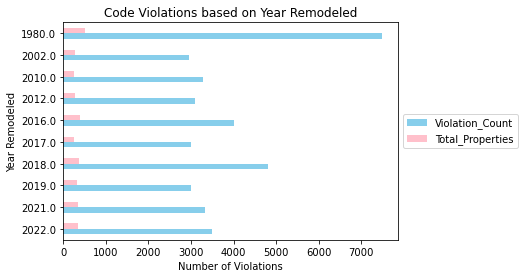

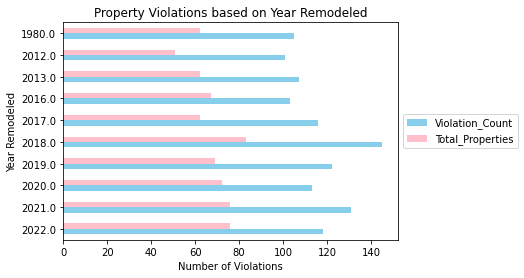

In [15]:
# Convert the data into a pandas Series
series = pd.Series(conditions_code).sort_index(ascending=False)
data_code = pd.DataFrame({'Violation_Count': series, 'Total_Properties': unique_code_series})
data_code_sorted = data_code

# Adding labels and title
ax = data_code_sorted.plot.barh(color=['skyblue','pink'], rot=0, title='Code Violations based on Year Remodeled')
plt.xlabel('Number of Violations')
plt.ylabel('Year Remodeled')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Convert the data into a pandas Series
series = pd.Series(conditions_prop).sort_index(ascending=False)
data_prop = pd.DataFrame({'Violation_Count': series, 'Total_Properties': unique_prop_series})
data_prop_sorted = data_prop

# Adding labels and title
ax = data_prop_sorted.plot.barh(color=['skyblue','pink'], rot=0, title='Property Violations based on Year Remodeled')
plt.xlabel('Number of Violations')
plt.ylabel('Year Remodeled')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

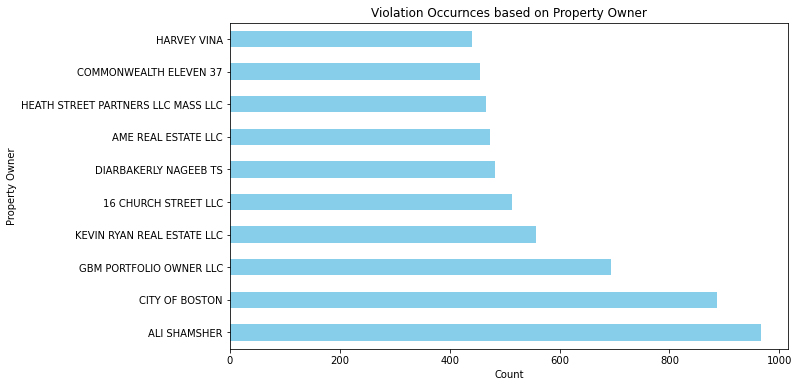

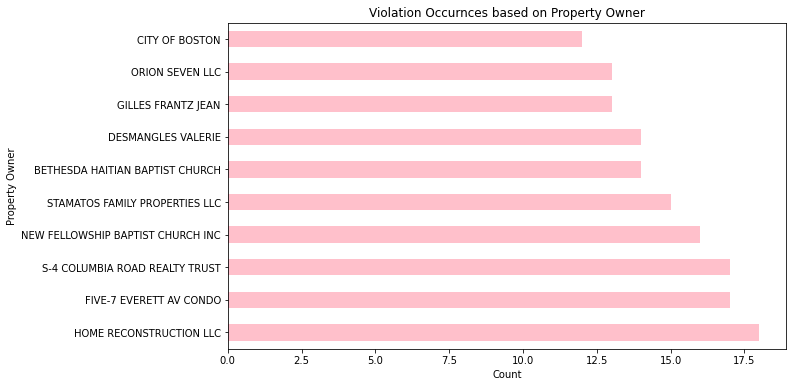

In [16]:
conditions_code = processed_code_vio.dropna(subset = ['OWNER'], inplace = False)['OWNER'].value_counts().head(10)
conditions_prop = processed_prop_vio.dropna(subset = ['OWNER'], inplace = False)['OWNER'].value_counts().head(10)

# Calculate the total number of properties owned by each property owner
total_properties_code = processed_code_vio.groupby('OWNER')['PID'].nunique()
total_properties_prop = processed_prop_vio.groupby('OWNER')['PID'].nunique()

# Convert the data into a pandas Series
series = pd.Series(conditions_code)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
series.plot(kind='barh', color='skyblue')

# Adding labels and title
plt.xlabel('Count')
plt.ylabel('Property Owner')
plt.title('Violation Occurnces based on Property Owner')

# Display the plot
plt.show()

# Convert the data into a pandas Series
series = pd.Series(conditions_prop)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
series.plot(kind='barh', color='pink')

# Adding labels and title
plt.xlabel('Count')
plt.ylabel('Property Owner')
plt.title('Violation Occurnces based on Property Owner')

# Display the plot
plt.show()

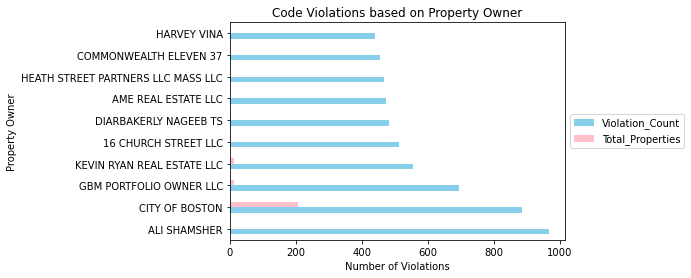

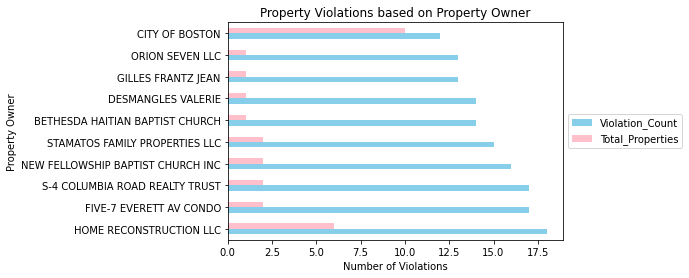

In [17]:
# Calculate the count of violations for the top 10 property owners
conditions_code = processed_code_vio.dropna(subset=['OWNER'], inplace=False)['OWNER'].value_counts().head(10)
conditions_prop = processed_prop_vio.dropna(subset=['OWNER'], inplace=False)['OWNER'].value_counts().head(10)

# Calculate the total number of properties owned by each property owner
# Filter the DataFrame for the top 10 property owners
top_owners = processed_code_vio.dropna(subset=['OWNER'], inplace=False)['OWNER'].value_counts().head(10).index
filtered_df = processed_code_vio[processed_code_vio['OWNER'].isin(top_owners)]

# Explode the 'full_address' column to flatten lists
flattened_df = filtered_df.explode('full_address')

# Count the number of unique properties for each property owner
unique_properties_count = flattened_df.groupby('OWNER')['full_address'].nunique()

# Build a Series with property owners as index
unique_code_series = pd.Series(unique_properties_count, index=top_owners)

# Repeat for property violations
top_owners = processed_prop_vio.dropna(subset=['OWNER'], inplace=False)['OWNER'].value_counts().head(10).index
filtered_df = processed_prop_vio[processed_prop_vio['OWNER'].isin(top_owners)]
flattened_df = filtered_df.explode('full_address')
unique_prop_count = flattened_df.groupby('OWNER')['full_address'].nunique()
unique_prop_series = pd.Series(unique_prop_count, index=top_owners)


# Combine the counts and total properties into a DataFrame
data_code = pd.DataFrame({'Violation_Count': conditions_code, 'Total_Properties': unique_code_series})
data_prop = pd.DataFrame({'Violation_Count': conditions_prop, 'Total_Properties': unique_prop_series})

# Plotting the bar chart for processed_code_vio dataset
ax = data_code.plot.barh(color=['skyblue','pink'], rot=0, title='Code Violations based on Property Owner')
ax.set_xlabel('Number of Violations')
ax.set_ylabel('Property Owner')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting the bar chart for processed_prop_vio dataset
ax = data_prop.plot.barh(color=['skyblue','pink'], rot=0, title='Property Violations based on Property Owner')
ax.set_xlabel('Number of Violations')
ax.set_ylabel('Property Owner')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



In [18]:
processed_code_vio.dropna(subset=['PID'], inplace=True)
processed_prop_vio.dropna(subset=['PID'], inplace=True)

df1 = processed_code_vio.dropna(subset=['YR_REMODEL'], inplace=False).dropna(subset=['YR_BUILT'], inplace=False)
df2 = processed_prop_vio.dropna(subset=['YR_REMODEL'], inplace=False).dropna(subset=['YR_BUILT'], inplace=False)

# Combine the columns into a new column
df1['Years'] = df1['YR_REMODEL'].astype(str) + '-' + df1['YR_BUILT'].astype(str)
df2['Years'] = df2['YR_REMODEL'].astype(str) + '-' + df2['YR_BUILT'].astype(str)

# Calculate violation counts based on 'Years'
conditions_code = df1['Years'].value_counts().head(10)
conditions_prop = df2['Years'].value_counts().head(10)

# Get the top 10 property owners based on 'Years' for processed_prop_vio
top_owners_code = df1['Years'].value_counts().head(10).index.sort_values(ascending=False)
top_owners_prop = df2['Years'].value_counts().head(10).index.sort_values(ascending=False)

# Filter for the top owners
filtered_code = df1[df1['Years'].isin(top_owners_code)].explode('full_address')
filtered_prop = df2[df2['Years'].isin(top_owners_prop)].explode('full_address')

# Count unique properties for each year remodeled
unique_code_count = filtered_code.groupby('Years')['full_address'].nunique()
unique_prop_count = filtered_prop.groupby('Years')['full_address'].nunique()

# Create a Series with property counts for each year remodeled
unique_code_series = pd.Series(unique_code_count, index=top_owners_code)
unique_prop_series = pd.Series(unique_prop_count, index=top_owners_prop)

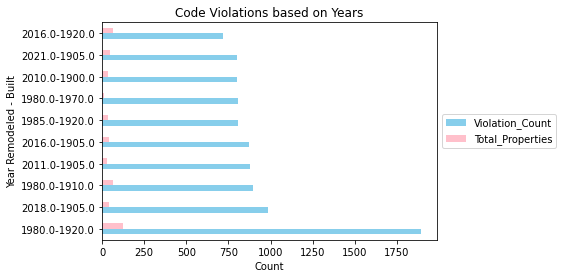

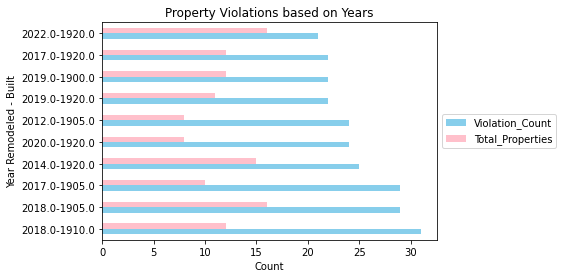

In [19]:
# Convert the data into a pandas Series
series = pd.Series(conditions_code).sort_index(ascending=False)
data_code = pd.DataFrame({'Violation_Count': series, 'Total_Properties': unique_code_series})
data_code_sorted = data_code.sort_values(by='Violation_Count', ascending=False)

# Adding labels and title
ax = data_code_sorted.plot.barh(color=['skyblue','pink'], rot=0, title='Code Violations based on Years')
plt.xlabel('Count')
plt.ylabel('Year Remodeled - Built')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Convert the data into a pandas Series
series = pd.Series(conditions_prop).sort_index(ascending=False)
data_prop = pd.DataFrame({'Violation_Count': series, 'Total_Properties': unique_prop_series})
data_prop_sorted = data_prop.sort_values(by='Violation_Count', ascending=False)

# Adding labels and title
ax = data_prop_sorted.plot.barh(color=['skyblue','pink'], rot=0, title='Property Violations based on Years')
plt.xlabel('Count')
plt.ylabel('Year Remodeled - Built')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()